In [3]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from IPython.display import Latex, display, Markdown
import entsoapi
from entsoe import EntsoePandasClient
client = EntsoePandasClient(api_key=entsoapi.mykey)

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import scipy.optimize as sco

> Saját adatok alapján, lehet energetikai, de más jellegű is, a lényeg a **kapcsolatvizsgálat számszerűsítése és értelmezése**. Adatgyűjtés, probléma pontos megfogalmazása, megfelelő **modell illesztése**, eredmények értelmezése kb 3-5 oldal + adatok.

Beadás április 30ig

# Leíró statisztika részvényadaton

Ebben a fejezetben az egyszerű leíró statisztikai számokat vizsgálom az OTP  számomra elérhető 2002-2021 közti napi OHLC adatsorán.
Az adatok forrása a yahoo Finance. A _yfinance_ python könyvtáron keresztül töltöm le az adatokat pandas dataframe-be. A nyers adatokat nem tárolom fájl szinten, memoriából dolgozom fel.

## Adatgyűjtés

In [2]:
otp = yf.Ticker("OTP.BD")
otp_hist = otp.history(period="max", auto_adjust = True)

In [3]:
otp_hist.iloc[:,:5].head()

,Open,High,Low,Close,Volume
Date,,,,,
2002-03-05,1544.885237,1611.094604,1531.643364,1611.094604,1726700
2002-03-06,1601.531007,1655.969819,1582.403857,1647.877563,898300
2002-03-07,1663.326440,1692.017165,1648.613247,1688.338867,763700
2002-03-08,1666.269061,1678.775274,1650.084549,1677.303955,402000
2002-03-11,1658.176851,1661.855150,1582.403907,1588.289185,439600


Az adattábla a napi OHLC adatsort, mennyiség oszlopokat(mezőket, tulajdonságokat) tartalmazza. A Close érték az valójában az esetleges részvény darabolás, osztalék és más a részvény árát, értékelését befolyásoló tényezőkel kiigazított _adjusted close_ érték.

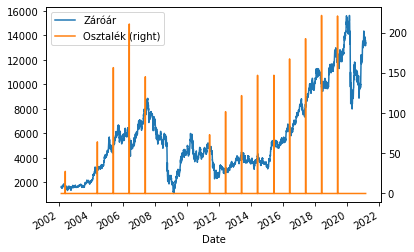

In [4]:
# Részvényárfolyam és osztalékfizetés
ax=otp_hist.Close.plot( label='Záróár', 
                       legend=True)
ax=otp_hist.Dividends.plot(secondary_y=True, 
                           label='Osztalék', 
                           legend=True)

## Hozam számolás

Hozam kiszámolható az egymást követő adatok hányadosaként vagy log hányadosaként is. A _log return_ ami a folyamatos kamatozásnak felel meg statisztikai tulajdonságait fogom részletesen vizsgálni.

In [5]:
# egyszerű hozam
otp_hist['simple_return'] = otp_hist.Close.pct_change()
# loghozam
otp_hist['log_return'] = np.log(otp_hist.Close/otp_hist.Close.shift(1))

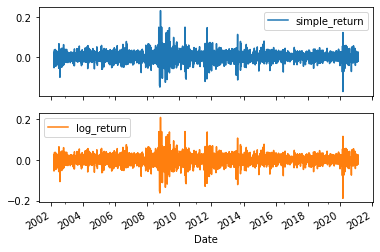

In [6]:
ax=otp_hist[['simple_return', 'log_return']].plot(subplots=True, layout=(2,1))

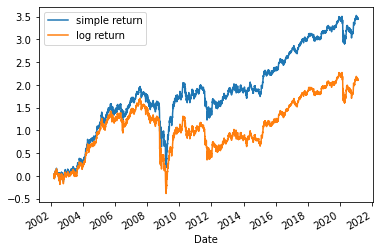

In [7]:
otp_hist.simple_return.cumsum().plot(label='simple return', legend='True')
ax=otp_hist.log_return.cumsum().plot(label='log return', legend='True')

In [8]:
a = otp_hist.Close[0] * np.exp(len(otp_hist)*otp_hist.log_return.mean())
b = otp_hist.Close[-1]

print(f'Az adatsor utolsó záró értéke az adatsor első értéke és a log hozam szorzataként: \
{a:.2f} vs az adatsor tényleges utolsó hozamértéke:{b:.2f}')

Az adatsor utolsó záró értéke az adatsor első értéke és a log hozam szorzataként: 13205.70 vs az adatsor tényleges utolsó hozamértéke:13200.00


## Hozam eloszlásának normalitásvizsgálata

A kérdés hogy a hozamot ha véletlenszerűnek tekintjük akkor az eloszlása normális eloszlást követ-e?

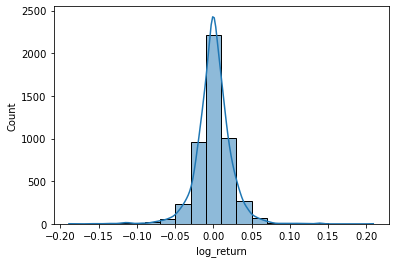

In [9]:
ax=sns.histplot(otp_hist.log_return,stat='count', kde=True, bins=20)

Ránézésre normális eloszlásnak tűnik, de ezt számokkal kell alátámasztani. Az eloszlás diagrammból mindenesetre kitűnik a 'long tail' mindkét oldalon.

### Kolmogorov-Smirnov teszt 
Azt vizsgálja hogy az eloszlás (illetve annak görbéje) mennyire hasonlít a normális eloszlás haranggörbéjéhez.

In [10]:
from scipy import stats
stats.kstest(otp_hist.log_return.dropna(), cdf='norm')

KstestResult(statistic=0.46706472513531716, pvalue=0.0)

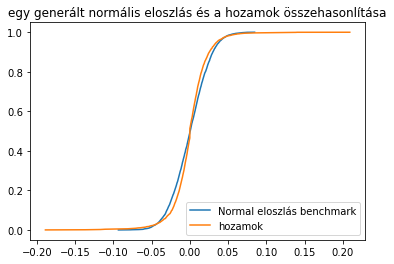

In [11]:
# készítek egy véletlenszerűen generált normális eloszlású sort
mu= otp_hist.log_return.dropna().mean()
sigma = otp_hist.log_return.dropna().std()
s = np.random.normal(mu, sigma, len(otp_hist.log_return.dropna()))
hmax = otp_hist.log_return.dropna().max()
hmin = otp_hist.log_return.dropna().min()

# összevetem a részvény hozam görbéjével
plt.figure()
plt.plot(np.sort(s), np.linspace(0, 1, len(s), endpoint=False))
plt.plot(np.sort(otp_hist.log_return.dropna()), 
         np.linspace(0, 1, len(otp_hist.log_return.dropna()), endpoint=False))
plt.legend('top right')
plt.legend(['Normal eloszlás benchmark', 'hozamok']) 
title='egy generált normális eloszlás és a hozamok összehasonlítása'
ax=plt.title(title)

### Paraméterpróba
Normális eloszlás ferdesége és csúcsossága egyaránt 0: ha akár a ferdeség, akár a csúcsosság szignifikánsan különbözik 0-tól akkor az eloszlás is szignifikánsan különbözik a normális eloszlástól. Ez egy alaki jellegű tesztelés

In [12]:
data = otp_hist.log_return.dropna()
print("Átlag     : ", np.mean(data))
print("Variancia : ", np.var(data))
print("Szórás    : ", np.std(data))
print("Ferdeség  : ", stats.skew(data))
print("Csúcsosság: ", stats.kurtosis(data))

Átlag     :  0.00043144676985479107
Variancia :  0.0005502543132457048
Szórás    :  0.023457500149114456
Ferdeség  :  -0.25374372674575474
Csúcsosság:  7.647240998644573


A csúcsosság tekintetében a normális eloszlás nem teljesül. Az ilyen leptokurtikus hozameloszlások jellemzőek részvényekre. POrtfolioépítésnél ezt is figyelembe kell venni.

## A részvény adatsor leíró statisztikái

In [13]:
print(otp_hist.describe(percentiles=[.5]).T.round(2))

                count        mean         std      min        50%          max
Open           4876.0     5697.60     3238.73  1069.88    4898.33     15580.00
High           4876.0     5763.69     3266.73  1215.77    4962.47     15850.00
Low            4876.0     5626.11     3211.37   998.56    4828.35     15520.00
Close          4876.0     5696.13     3240.38  1098.25    4894.66     15630.00
Volume         4876.0  1279330.51  1391199.61     0.00  848372.50  26698424.00
Dividends      4876.0        0.41        8.23     0.00       0.00       221.35
Stock Splits   4876.0        0.00        0.00     0.00       0.00         0.00
simple_return  4875.0        0.00        0.02    -0.17       0.00         0.23
log_return     4875.0        0.00        0.02    -0.19       0.00         0.21


**Összefoglalás**: Az OTP  elmult 19 évének részvényárfolyamából számolt learó statisztikákat számolta(tta)m ki.

# Villamosenergia day ahead árak és fogyasztás kapcsolatának vizsgálata
Ebben a részben a HUPX Day ahead árak és a magyar villamosenergia rendszer fogyasztási görbéjét vizsgálom, egy tetszőleges napra vonatkozólag. A DAM árak T-1 napi aukció során alakultak ki. 

## Adatgyűjtés

Adatok letöltése az ENTSOE transparency platformról. Hupx jelöli a DAM árak tábláját, load pedig a terhelési adatokat.

In [14]:
country_code = 'HU'
start = pd.Timestamp('202102150000', tz='Europe/Brussels')
end = pd.Timestamp('202102152345', tz='Europe/Brussels')

hupx = client.query_day_ahead_prices(country_code, start=start,end=end)
load=client.query_load(country_code, start=start,end=end)

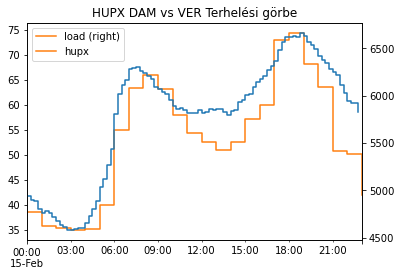

In [15]:
load.plot(secondary_y=True, drawstyle='steps-post', label='load', legend=True)
a = hupx.plot(drawstyle='steps-post', label='hupx', legend=True, 
              title =f'HUPX DAM vs VER Terhelési görbe')

Egy gyors regplot, hogy egyáltalán van e értelme vizsgálódnom:

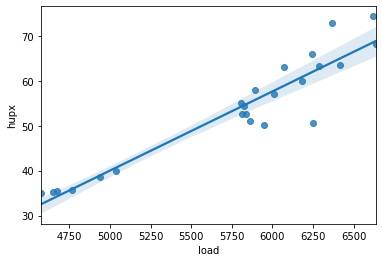

In [16]:
df = pd.DataFrame()
df['load'] = load
df['hupx'] = hupx
df.dropna(inplace=True)
ax = sns.regplot(x="load", y="hupx", data=df)

## Kétváltozós lineáris regressziós modell (kézi számolással)

X tengelyen a terhelési görbe ami az okozó tényező Y tengelyen a hupx DA árak.

$Y = \beta_0 + \beta_1X$

## Legkisebb négyzetek módszere
Munkatábla; az idősor tengelyre nincs szükség.

In [17]:
#X = load; Y= hupx
df['XiYi'] = df.load*df.hupx
df['Xi2'] = df.load*df.load
df.dropna()
df.head(3)

,load,hupx,XiYi,Xi2
2021-02-15 00:00:00+01:00,4942.0,38.53,190415.26,24423364.0
2021-02-15 01:00:00+01:00,4764.0,35.70,170074.80,22695696.0
2021-02-15 02:00:00+01:00,4676.0,35.42,165623.92,21864976.0


## Normálegyenletek megoldása determináns módszerrel

In [18]:
sumY = df.hupx.sum()
sumX2 = df['Xi2'].sum()
sumX = df.load.sum()
sumXY = df.XiYi.sum()
n = len(df)
b0= (sumY*sumX2-(sumX*sumXY))/(n*sumX2-(sumX*sumX))
b1 = (n*sumXY-sumY*sumX)/(n*sumX2-(sumX*sumX))
display(Latex(f'$\\beta_0:${b0:4f} $\\beta_1:${b1:4f}'))

<IPython.core.display.Latex object>

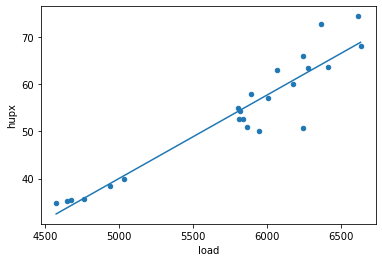

In [19]:
df.plot.scatter(x='load', y='hupx')
x_values = np.linspace(df.load.min(),df.load.max(),2)
y_linreg_values = b0+b1*x_values
ax=plt.plot(x_values,y_linreg_values)

In [20]:
print(f'A regressziófüggvény:Y = {b0:.2f} + {b1:.4f} X')
print(f'A villamosenergia fogyasztás 100 MWh-val való \
növekedése átlagosan {b1*100:.4f} EUR/MWh-val növelte \
a HUPX DA árait a vizsgált időszakban.')

A regressziófüggvény:Y = -48.28 + 0.0177 X
A villamosenergia fogyasztás 100 MWh-val való növekedése átlagosan 1.7656 EUR/MWh-val növelte a HUPX DA árait a vizsgált időszakban.


## Rugalmassági együttható

In [21]:
# : E(Y, X=5500)
X = 5500
E = b1 * X/(b0+b1*X)
print(f'Ha {X} MWh lett volna a fogyasztás és az 1%-kal nő, akkor az ár {E:.3f} EUR-ral nőne.')

Ha 5500 MWh lett volna a fogyasztás és az 1%-kal nő, akkor az ár 1.989 EUR-ral nőne.


## Lineáris korreláció szorossága

In [22]:
# covariance önmagában nem tul értelmes
df[['hupx', 'load']].cov()

,hupx,load
hupx,150.264585,7582.869012
load,7582.869012,429489.885375


In [23]:
# correlation normalizálja a covariance-t -1..+1 közé
df[['hupx', 'load']].corr()

,hupx,load
hupx,1.000000,0.943906
load,0.943906,1.000000


In [24]:
# ellenőrzés a scipy. stats-ból
import string
meredekség, tengelymetszet, r, pvalue, stderr = stats.linregress(df.load, df.hupx)

egyenlet = 'y = {:.2f}+{:.4f}x'.format(tengelymetszet,meredekség )
r = {'egyenlet': egyenlet,
    'r': f'{r:.4f}',
    'p': f'{pvalue:.4f}',
    'stderr': f'{stderr:.4f}'}

report = string.Template("""
HUPX DAM ár és VER fogyasztási adatok közötti kapcsolatvizsgálat
Ellenőrzése scipy.stats-szal
=================================================
Regressziós egyenlet : $egyenlet
Korreláció (r)       : $r
p érték              : $p
standard hiba        : $stderr
""")
print(report.substitute(r))



HUPX DAM ár és VER fogyasztási adatok közötti kapcsolatvizsgálat
Ellenőrzése scipy.stats-szal
Regressziós egyenlet : y = -48.28+0.0177x
Korreláció (r)       : 0.9439
p érték              : 0.0000
standard hiba        : 0.0013



Korreláció csak annyit jelent hogy együtt mozognak, nem azt hogy ok-okozati kapcsolat is van köztük. Hogy a HUPX DAM ár ami T-1 napi aukció nyomán születik meg az aukcióra beadott mennyiségek és árak kereslet kínálati összevetéséből és a T napi fogyasztási görbe amit előző napon a piaci szereplők menetrendeznek, forecastolnak, arra már korábban határidős és más ügyletekkel mennyiségeket lekötnek együtt mozog így teljesen el is fogadható. 
A 94% feletti pozitív  korreláció nagyon erősnek számít.

# A BÉT néhány részvényének korrelációs mátrixa

*Probléma*: Itt találomra kiválasztottam 10 BÉTen forgó részvényt és a 2020-as adataik alapján a köztük 3-5 leginkább ellentétesen mozgókat (uncorrelated assets)  fogom felhasználni a következő fejezetben a portfólió finomításához.

In [25]:
assets = "4IG.BD BIF.BD ALTEO.BD ANY.BD RABA.BD AKKO.BD DELTA.BD OTP.BD MOL.BD OPUS.BD"
data = yf.download(assets, start="2020-01-01", end="2020-12-31")
data['Adj Close'].iloc[:, :7].head(3)

[*********************100%***********************]  10 of 10 completed


,4IG.BD,AKKO.BD,ALTEO.BD,ANY.BD,BIF.BD,DELTA.BD,MOL.BD
Date,,,,,,,
2020-01-02,678.775269,440.0,850.0,1296.597534,298.934845,127.0,2960.0
2020-01-03,636.351807,438.0,882.0,1296.597534,299.902283,126.0,2950.0
2020-01-06,652.742676,424.0,892.0,1287.336060,300.869720,123.0,2882.0


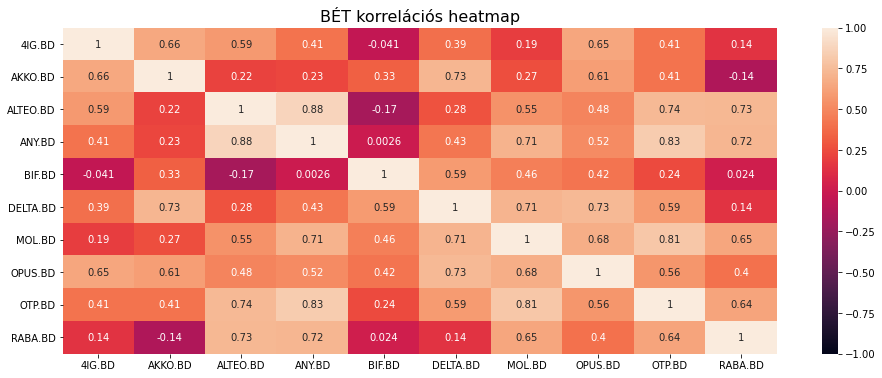

In [26]:
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(data['Adj Close'].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('BÉT korrelációs heatmap', fontdict={'fontsize':16});

## TOP 5 legmagasabb korrelációs pár

In [27]:
def get_redundant_pairs(df):
    pairs_to_drop = set() # set-ben nem lehet ismétlődés
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5, asc=False):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=asc)
    return au_corr[0:n]

print("Top 5 legnagyobb absolut együttmozgó pár")
print(get_top_abs_correlations(data['Adj Close'],5, False))
print('\n')
print("Top 5 legkevésbé együttmozgó pár")
print(get_top_abs_correlations(data['Adj Close'],5, True))

Top 5 legnagyobb absolut együttmozgó pár
ALTEO.BD  ANY.BD     0.880457
ANY.BD    OTP.BD     0.833225
MOL.BD    OTP.BD     0.805395
ALTEO.BD  OTP.BD     0.740496
DELTA.BD  OPUS.BD    0.734477
dtype: float64


Top 5 legkevésbé együttmozgó pár
ANY.BD   BIF.BD     0.002568
BIF.BD   RABA.BD    0.023809
4IG.BD   BIF.BD     0.040921
AKKO.BD  RABA.BD    0.135017
4IG.BD   RABA.BD    0.142096
dtype: float64


Ezzel megvannak azok az eszközök amelyeket portfólióépítéshez használhatok.  A legkevésbé együttmozgó instrumentumokkal lehet a portfóliót kiegyensúlyozni. Az eszközök kiválasztására pedig a kiigazított záróárakra alkalmazott korrelációs számítást használtam.

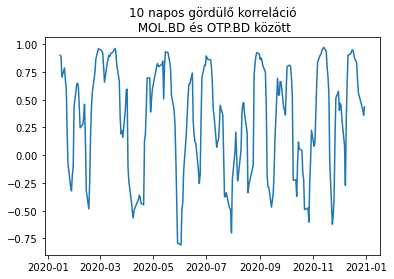

In [28]:
# Gördülő korreláció: a korreláció időbeli változását mutatja 2 részvény között
n=10
r1 = 'MOL.BD'
r2 = 'OTP.BD'
rolling_correlation = data['Close']['MOL.BD'].rolling(n).corr(data['Close']['OTP.BD'])
plt.title(f'{n} napos gördülő korreláció\n {r1} és {r2} között')
ax=plt.plot(rolling_correlation)

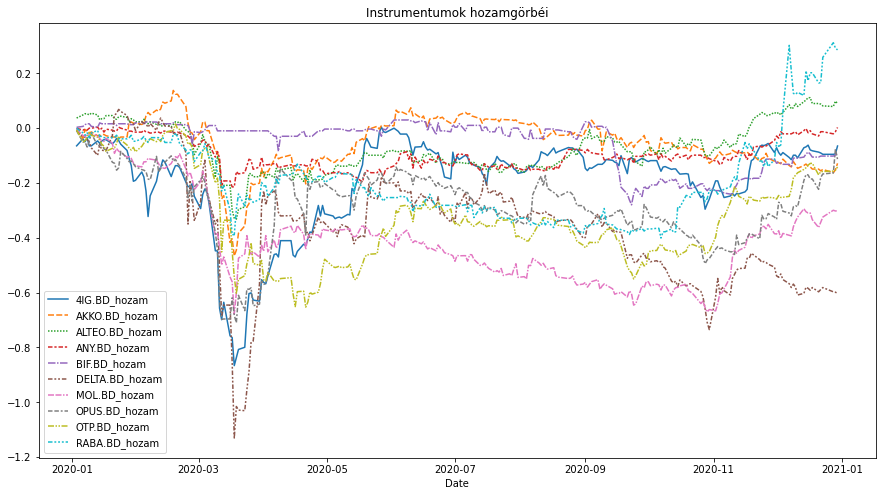

In [29]:
data2 = pd.DataFrame()
for c in data['Adj Close'].columns:
    colname = c+'_hozam'
    data2[colname] = np.log(data['Adj Close'][c]/data['Adj Close'][c].shift(1))

plt.figure(figsize=(15,8))
plt.title('Instrumentumok hozamgörbéi')
ax=sns.lineplot(data=data2.cumsum())

# Idősorelemzés VER 2020-2021Q1
A magyar villamosenergia rendszer terhelési görbéjét fogom elemezni 2020.01.01-től 2021.02.15ig.
Az adatokat az Entsoe transparency platform API-ról töltöm le.

## AdatLetöltés

In [30]:
# Terhelési görbe (tg) adatok lekérdezése
start = pd.Timestamp('202001010000', tz='Europe/Brussels')
end   = pd.Timestamp('202102162345', tz='Europe/Brussels')
tg    = client.query_load('HU', start=start,end=end)

## Adattábla egyszerű vizsgálata

In [31]:
# Adatsor első pár sora
print(tg.head())

# Intervallum explicit beadása.. erre most nem lesz szükség
# tg = tg.asfreq(freq='15min')

# Van e null érték az adatsorban?
print(f'Null érték van-e? {tg.isnull().any()}')

2020-01-01 00:00:00+01:00    4374.0
2020-01-01 00:15:00+01:00    4324.0
2020-01-01 00:30:00+01:00    4284.0
2020-01-01 00:45:00+01:00    4220.0
2020-01-01 01:00:00+01:00    4173.0
dtype: float64
Null érték van-e? False


In [32]:
# Adatsor leíró statisztikái
print(tg.describe().round(2))

count    39632.00
mean      4957.02
std        803.66
min       2998.00
25%       4363.00
50%       4925.00
75%       5551.25
max       6827.00
dtype: float64


Az első lényeges megfigyelést itt tehetjük: 2020 január 1 től a magyar VER terhelésének minimum és maximum értékei meghatározhatóak. A fenti leíró statisztika megmutatja az adattípust is (float) azaz nem kell konvertálni és statisztikai elemzésre az adat így alkalmas. <BR>
Az időpecsét UTC időzona formátumban van, ami az óraátállítások kezelése miatt szükséges, főleg ha az ENTSOE adatbázisából mondjuk Romániával akarnám összehasonlítani az adatokat.

## Vizualizálás

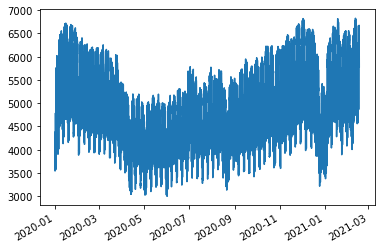

In [33]:
ax=tg.plot()

Az egész időszaknyi  negyedórás adat kirajzolása egy sűrű grafikont eredményez. Az látszik belőle hogy idősor, ciklikusság van benne, vannak szakaszai amelyekben trend is megfigyelhető. Kiugró értékeket itt nem lehet megállapítani. Első ránézésre csak annyit tudok mondani róla hogy elemzésre alkalmas lesz.

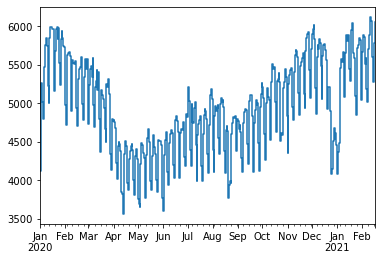

In [34]:
# Adatsor aggregálása napi átlagok szintjére. 
ax = tg.resample('d').mean().plot(drawstyle='steps-post')

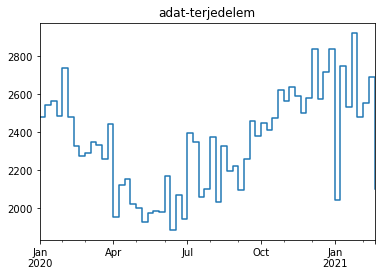

In [35]:
ax = (tg.resample('w').max()-tg.resample('w').min()).plot(drawstyle='steps-post', title = 'adat-terjedelem')

Heti agregált adat szélessége. Juniusban a legalacsonyabb a  heti minimum és maximum közti különbség, a téli hónapokban pedig a legmagasabb.

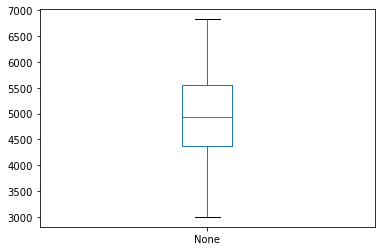

In [36]:
ax=tg.plot(kind='box')

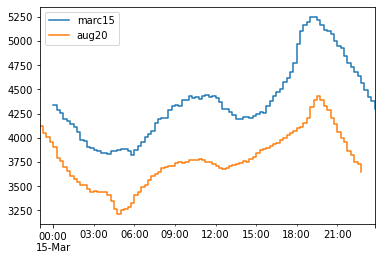

In [37]:
# két adott nap, március 15-e és augusztus 20 megjelenítése 
# naptípusonkénti elemzés majd lejjebb
ax=tg.loc['2020-03-15 00:00':'2020-03-15 23:45'].plot(drawstyle='steps-post', label='marc15', legend=True)
ax=tg.loc['2020-08-20 00:00':'2020-08-20 23:45'].shift(-158, freq='D').plot(drawstyle='steps-post', label='aug20', legend=True)

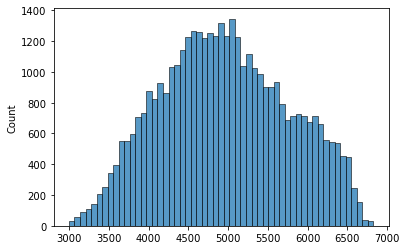

In [38]:
ax= sns.histplot(tg)

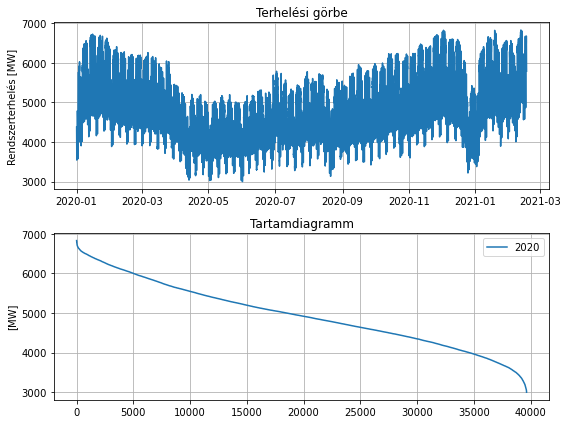

In [39]:
# Tartamgörbe
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])

plt.subplot(2,1,1)
plt.plot(tg)
plt.ylabel('Rendszerterhelés [MW]')
plt.grid(True)
plt.title('Terhelési görbe')

plt.subplot(2,1,2)
plt.plot(tg.sort_values(ascending=False).to_list(), label='2020')
plt.ylabel('[MW]')
plt.title('Tartamdiagramm')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [40]:
print('Max Load: \t{}, {} MW'.format(tg.idxmax(), tg.max()))
print('Min Load: \t{}, {} MW'.format(tg.idxmin(), tg.min()))
peak = tg.between_time('08:00', '20:00')
print('Max Peak Load: \t{}, {} MW'.format(peak.idxmax(), peak.max()))
print('Min Peak Load: \t{}, {} MW'.format(peak.idxmin(), peak.min()))

Max Load: 	2021-02-11 17:45:00+01:00, 6827.0 MW
Min Load: 	2020-06-01 05:30:00+02:00, 2998.0 MW
Max Peak Load: 	2021-02-11 17:45:00+01:00, 6827.0 MW
Min Peak Load: 	2020-04-12 13:45:00+02:00, 3361.0 MW


A maximális _rendszerterhelés_ már 2021-ben volt. A minimális rendszerterhelés pedig nem a  2020 áprilisi első pandemiahullám idején.

## Stacionaritás vizsgálata

Egy idősor akkor tekinthető stacionáriusnak ha az idősor maradék tagjának 
- várható értéke, 
- varianciája, 
- autokovarianciája

nem függ az időtől. Ilyen esetben a folyamat lefutása az időben stabil, nincs trendhatás. Az ilyen idősoroknak jó a rövid távú előrejelezhetősége.

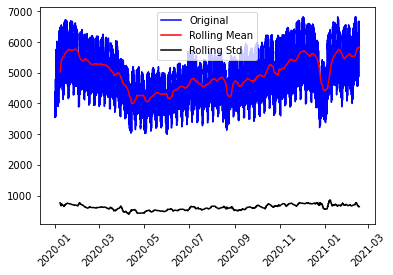

In [41]:
rolmean = tg.rolling(window = 96*7, center = False).mean()
rolstd = tg.rolling(window = 96*7, center = False).std()
orig = plt.plot(tg,color = 'blue',label = 'Original')
mean = plt.plot(rolmean,color = 'red',label = 'Rolling Mean')
std = plt.plot(rolstd,color = 'black',label = 'Rolling Std')
plt.legend(loc = 'best')
plt.xticks(rotation = 45)
plt.show(block = False)
plt.close()

In [42]:
dftest = adfuller(tg)
print(f'Test Statistic: {dftest[0]:.4f}')
print(f'p value: {dftest[1]:.8f}')
for key, value in dftest[4].items():
    print(f'Critical value {key}: {value:.4f}')
    
if dftest[0] < dftest[4]["5%"]:
    print ("Ho elutasítható: Az idősor stacioner")
else:
    print ("Ho nem elutasítható - Az idősor NEM stacioner")

Test Statistic: -13.6729
p value: 0.00000000
Critical value 1%: -3.4305
Critical value 5%: -2.8616
Critical value 10%: -2.5668
Ho elutasítható: Az idősor stacioner


ADF teszt esetén a Ho hipotézis az hogy az adatsor NEM stacionárius. Ha a Test statisztika < Critical value akkor elutasíthatjuk a Ho-t. Jelen esetben ez igaz tehát az adatsor stacionárius. Ami, ha belegondolok végülis valós, hiszen egy gazdaság terhelési görbéje csak akkor "trendelne" ha vagy hatalmas gazdasági növekedés lenne ami már egy ilyen 12-13 hónapos időszakban is érzékelhető lenne, vagy - és erre volt esély - olyan mély válság alakulna ki  hogy tartosan és folyamatosan csökkenne a villamos energia igény iránti igény. De a fenti időszakban a géppark, erőműpark nem változott jelentősen és a pandemia hatása is csak az év március-április hónapjaira koncentrálódott, legalábbis villamosenergia fogyasztás szempontjából.

## Idősor szétbontása

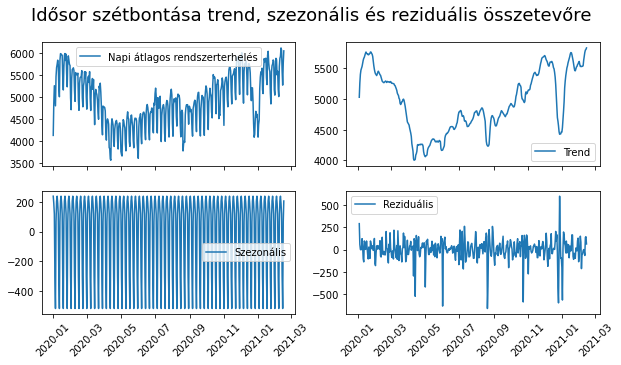

In [43]:
decomposition = seasonal_decompose(tg.resample('d').mean())

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (10, 5), sharex = True)

ax1.plot(tg.resample('d').mean(), label = 'Napi átlagos rendszerterhelés')
ax1.legend(loc = 'best')
ax1.tick_params(axis = 'x', rotation = 45)

ax2.plot(decomposition.trend, label = 'Trend')
ax2.legend(loc = 'best')
ax2.tick_params(axis = 'x', rotation = 45)

ax3.plot(decomposition.seasonal,label = 'Szezonális')
ax3.legend(loc = 'best')
ax3.tick_params(axis = 'x', rotation = 45)

ax4.plot(decomposition.resid, label = 'Reziduális')
ax4.legend(loc = 'best')
ax4.tick_params(axis = 'x', rotation = 45)

# Show graph
plt.suptitle('Idősor szétbontása trend, szezonális és reziduális összetevőre',
            fontsize = 18)
plt.show() 

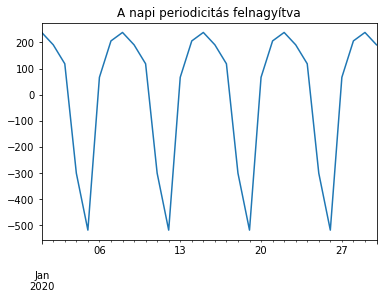

In [44]:
t='A napi periodicitás felnagyítva'
ax=decomposition.seasonal.loc['2020-01-01':'2020-01-30'].plot(title=t)

In [45]:
# szezonalitás átlaga

A rendszerterhelést szétbontottam az idősorban rejlő alapirányzatra, periodikus ingadozásra és egy véletlenszerű komponensre. Ez utóbbinál a kiugró értékek további vizsgálatot igényelnek.

## ARIMA model

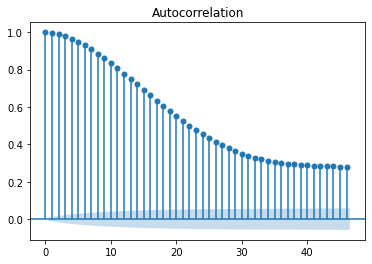

In [46]:
acf =sm.graphics.tsa.plot_acf(tg)

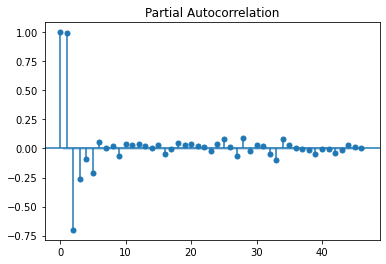

In [47]:
pacf=sm.graphics.tsa.plot_pacf(tg)

In [48]:
from statsmodels.tsa.arima.model import ARIMA
arima = ARIMA(tg.resample('h').mean(), order=(2,1,1)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9911
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -61555.313
Date:                Mon, 22 Feb 2021   AIC                         123118.625
Time:                        20:06:37   BIC                         123147.431
Sample:                    01-01-2020   HQIC                        123128.380
                         - 02-16-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6901      0.005    336.416      0.000       1.680       1.700
ar.L2         -0.8017      0.004   -206.199      0.000      -0.809      -0.794
ma.L1         -0.9510      0.004   -242.762      0.000      -0.959      -0.943
sigma2      1.455e+04    144.591    100.658      0.000    1.43e+04    1.48e+04
===================================================================================
Ljung-Box (L1) (Q):                 112.66   Jarque-Bera (JB):              4064.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
import scipy.stats as scs

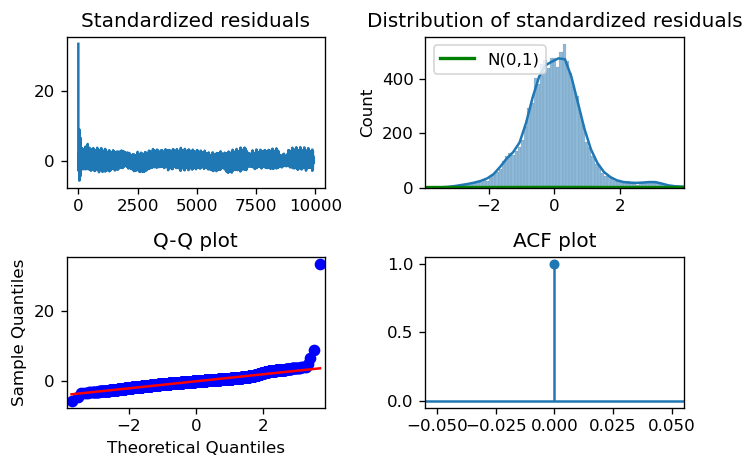

In [50]:
resids = arima.resid
n_lags = 40

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.dpi = 120
r = resids
resids = (r - np.nanmean(r)) / np.nanstd(r)
resids_nonmissing = resids[~(np.isnan(resids))]

# residuals over time
sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
ax1.set_title('Standardized residuals')

# distribution of residuals
x_lim = (-1.96 * 2, 1.96 * 2)
r_range = np.linspace(x_lim[0], x_lim[1])
norm_pdf = scs.norm.pdf(r_range)
sns.histplot(resids_nonmissing, kde=True, ax=ax2)
ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
ax2.set_title('Distribution of standardized residuals')
ax2.set_xlim(x_lim)
ax2.legend()

# Q-Q plot
qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
ax3.set_title('Q-Q plot')

# ACF plot
sm.graphics.tsa.plot_pacf(resids, ax=ax4, lags=n_lags, alpha=0.05)
x=ax4.set_title('ACF plot')
plt.tight_layout()

In [51]:
arima.resid.values

array([ 4.30050000e+03, -3.43147145e+02, -9.41935053e+01, ...,
       -7.13180740e+01, -3.26297056e+00, -4.04459148e+01])

In [52]:
xresid = arima.resid.values[~np.isnan(arima.resid.values)]
ljung_box_results = sm.stats.acorr_ljungbox(xresid, lags=[20], return_df=True)
ljung_box_results.round(4)

,lb_stat,lb_pvalue
20,604.0584,0.0


In [53]:
def run_arima_model(ts, p, d, q):    
    model = ARIMA(ts, order=(p, d, q))  
    results_ = model.fit()  
    
    len_results = len(results_.fittedvalues)
    ts_modified = ts[-len_results:]

    # calculate residual sum of squares (RSS)
    rss = sum((results_.fittedvalues - ts_modified)**2)
    # calculate root mean square error (RMSE)
    rmse = np.sqrt(rss / len(ts))

    plt.plot(ts)
    plt.plot(results_.fittedvalues, color = 'red')
    plt.title('For ARIMA model (%i, %i, %i) for ts , RSS: %.4f, RMSE: %.4f' %(p, d, q,  rss, rmse))
    plt.show()
    plt.close()

    return results_

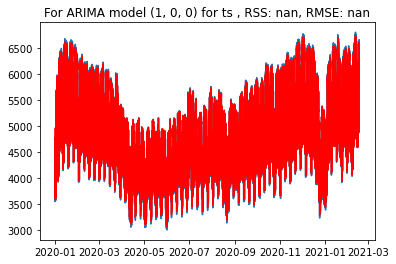

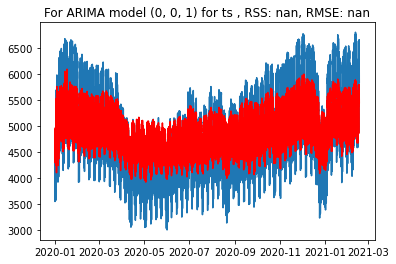

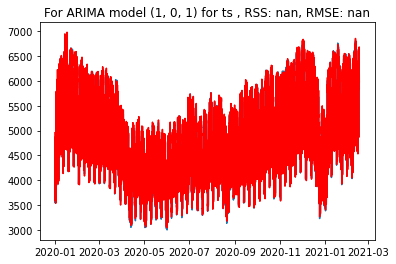

In [128]:
ts = tg.resample('h').mean()

model_AR   = run_arima_model(ts,p=1,d=0,q=0)
model_MA   = run_arima_model(ts,p=0,d=0,q=1)
model_ARMA = run_arima_model(ts,p=1,d=0,q=1)

TODO: Forecasting 

# Beta, CAPM, Optimális portfólió

Ez a fejezet már a befektetéselemzési óránkhoz tartozik, de mivel a kockázathoz kapcsolódó elemzések szintén korrelációt, szórást használnak ezért ide rakom.

- először kiszámolom 1 eszköznek a kockázatát ( mondjuk OTP idén)
- aztán 4 eszközre építek egy portfóliót és annak a kockázatát. a 4 elem súlya random
- majd generálok egy N elemű fiktiv portfoliót amit felhelyezek a kockázat-hozam síkra és ott meghatározom a hatékony portfoliók görbéjét.

Ez utóbbi már elég nehéz így itt 3 forrást is felhasználok 
- Brealey Myers- Modern Vállalati Pénzügyek II rész, 8. fejezet
- sajna 2019-ben megszűnt de kiváló quant elemzéskurzusa volt a quantopian-nak 
- Erik Lewinson - Python for Finance, Packt, 2020

## CAPM

In [55]:
RISKY_ASSET = 'OTP.BD'
MARKET_BENCHMARK = '^BUX'
START_DATE = '2021-01-01'
END_DATE = '2021-02-20'

In [56]:
df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True,
                 progress=False)

In [57]:
X = df['Adj Close'].rename(columns={RISKY_ASSET: 'asset', MARKET_BENCHMARK: 'market'}) \
.resample('D').last().pct_change().dropna()

In [58]:
covariance = X.cov().iloc[0,1]

benchmark_variance = X.market.var()
beta = covariance / benchmark_variance

In [59]:
beta

0.8522841027975474

In [60]:
y = X.pop('asset')
X = sm.add_constant(X)
capm_model = sm.OLS(y, X).fit()
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     37.83
Date:                Mon, 22 Feb 2021   Prob (F-statistic):           2.03e-07
Time:                        20:06:49   Log-Likelihood:                 154.13
No. Observations:                  46   AIC:                            -304.3
Df Residuals:                      44   BIC:                            -300.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -0.719      0.4

Ezek szerint ha a BUX-ot vesszük a piacnak és az OTP-BUX Beta-jat nézzük. Akkor a vizsgált időszakra a beta 0.5313 azaz az OTP fele olyan volatilis mint a piac egésze.

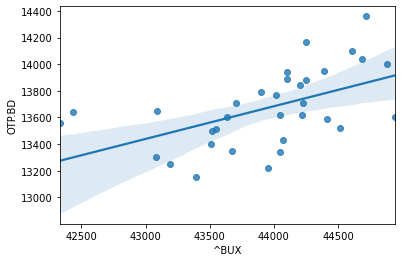

In [61]:
ax = sns.regplot(y=RISKY_ASSET, x=MARKET_BENCHMARK, data=df['Adj Close'])

## Eszköz allokáció

Ebben a részben Monte Carlo szimulációval keresem meg a hatékony portfolió görbéjét. Ez gyakorlatiag egy optimalizálási probléma egy kockázat hozam síkon. 

In [22]:
# paraméterek beállítása
RISKY_ASSETS = ['OTP.BD', 'ZWACK.BD', 'MOL.BD', '4IG.BD']
START_DATE   = '2020-01-01'
END_DATE     = '2020-12-31'

In [23]:
# adatok letöltése
prices_df = yf.download(RISKY_ASSETS, start=START_DATE,end=END_DATE, adjusted=True)
N_DAYS = len(prices_df)

[*********************100%***********************]  4 of 4 completed


In [24]:
# Hozam
returns_df = prices_df['Adj Close'].pct_change().dropna()
returns_df.head()

,4IG.BD,MOL.BD,OTP.BD,ZWACK.BD
Date,,,,
2020-01-03,-0.062500,-0.003378,-0.006498,0.005698
2020-01-06,0.025758,-0.023051,-0.042511,-0.008499
2020-01-07,-0.010340,-0.003470,0.004098,0.005714
2020-01-08,0.014925,0.005571,0.011565,0.000000
2020-01-09,-0.029412,0.000693,0.019502,0.002841


In [25]:
# várható éves hozam 
avg_returns = returns_df.mean() * N_DAYS
avg_returns

4IG.BD      0.090246
MOL.BD     -0.214637
OTP.BD     -0.033649
ZWACK.BD   -0.036932
dtype: float64

Egyszerű hozam számítással látható, hogy a 4 részvényből csak a 4IG ért el pozitív hozamot a pandémia első évében.

In [26]:
# covariance mátrix évesítve
cov_mat = returns_df.cov() * N_DAYS
cov_mat

,4IG.BD,MOL.BD,OTP.BD,ZWACK.BD
4IG.BD,0.306985,0.097555,0.106358,0.009266
MOL.BD,0.097555,0.175872,0.087781,0.012422
OTP.BD,0.106358,0.087781,0.212517,0.018042
ZWACK.BD,0.009266,0.012422,0.018042,0.013789


A részvények kovarianciamátrixjának átlóján szórásnégyzetek találhatók, a többi elem a megfelelő valószínűségi változók illetve koordináták (közötti lineáris kapcsolatot jelző) kovarianciája.

In [27]:
n_assets = len(RISKY_ASSETS)
np.random.seed(42) # ez csak annyi hogy az én gépem randomja reprodukálható legyen

# portfolio Random súlyokkal
N_PORTFOLIOS = 10
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
# weights =np.array([0.25, 0.25, 0.25, 0.25])

# az alábbi sor azért kell hogy a random portolio mátrix összege 1 legyen
weights /= np.sum(weights, axis=1)[:, np.newaxis]
weights[:3]

array([[0.14102156, 0.35796222, 0.27560979, 0.22540643],
       [0.12620081, 0.1261813 , 0.04698284, 0.70063506],
       [0.2613905 , 0.30790022, 0.00895102, 0.42175826]])

#### Portfolió mérőszámok

In [28]:
#Itt fent létrehozott súlyok mátrixát szorzom össze az éves portfolio hozammal
portf_rtns = np.dot(weights, avg_returns)
portf_rtns

array([-0.08170377, -0.04315047, -0.05837461,  0.01181367, -0.07116819,
        0.0013592 , -0.0782953 ,  0.01182295, -0.09330918, -0.02145381])

In [29]:
portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T,np.dot(cov_mat, weights[i]))))
    
portf_vol = np.array(portf_vol)
portf_vol

array([0.29284288, 0.1592464 , 0.24941476, 0.39270901, 0.30664339,
       0.32461394, 0.28898811, 0.37321482, 0.27813419, 0.29918168])

In [30]:
portf_sharpe_ratio = portf_rtns / portf_vol
portf_sharpe_ratio

array([-0.27900207, -0.27096666, -0.23404634,  0.0300825 , -0.23208781,
        0.00418712, -0.27092913,  0.03167868, -0.3354826 , -0.07170829])

In [31]:
# dataframesítés
portf_results_df = pd.DataFrame({'returns': portf_rtns, 
                                 'volatility': portf_vol,
                                 'sharpe_ratio':portf_sharpe_ratio})
portf_results_df

,returns,volatility,sharpe_ratio
0,-0.081704,0.292843,-0.279002
1,-0.043150,0.159246,-0.270967
2,-0.058375,0.249415,-0.234046
3,0.011814,0.392709,0.030082
4,-0.071168,0.306643,-0.232088
5,0.001359,0.324614,0.004187
6,-0.078295,0.288988,-0.270929
7,0.011823,0.373215,0.031679
8,-0.093309,0.278134,-0.335483
9,-0.021454,0.299182,-0.071708


In [32]:
# Határvonal pontjainak meghatározása
N_POINTS = 10*5
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(),
                            portf_results_df.returns.max(),
                            N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))

portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

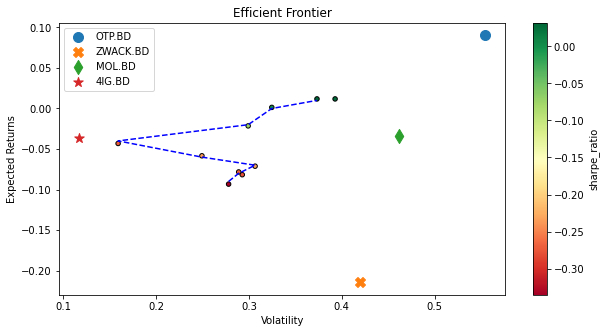

In [33]:
def PlotPortfolio():
    MARKS = ['o', 'X', 'd', '*']

    fig, ax = plt.subplots(figsize=(10,5))
    portf_results_df.plot(kind='scatter', 
                          x='volatility',
                          y='returns', 
                          c='sharpe_ratio',
                          cmap='RdYlGn', edgecolors='black',ax=ax)

    ax.set(xlabel='Volatility',
           ylabel='Expected Returns',
           title='Efficient Frontier')

    ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')

    for asset_index in range(n_assets):
        ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]),
                   y=avg_returns[asset_index],
                   marker=MARKS[asset_index],
                   s=100,               
                   label=RISKY_ASSETS[asset_index])
    ax=ax.legend()
PlotPortfolio()

Ez elég furán néz ki nem éppen a Markovitz görbe. Lássuk hogy nézne ez ki 10000 szimulált aszközzel:    

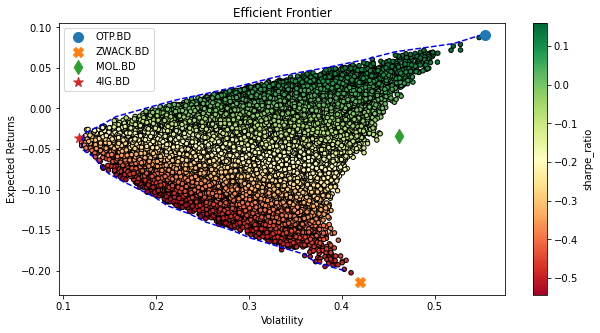

In [34]:
N_PORTFOLIOS = 10**5

np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
# az alábbi sor azért kell hogy a random portolio mátrix összege 1 legyen
weights /= np.sum(weights, axis=1)[:, np.newaxis]
weights[:3]

portf_rtns = np.dot(weights, avg_returns)
portf_rtns

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T,np.dot(cov_mat, weights[i]))))
    
portf_vol = np.array(portf_vol)
portf_vol

portf_sharpe_ratio = portf_rtns / portf_vol
portf_sharpe_ratio

portf_results_df = pd.DataFrame({'returns': portf_rtns, 
                                 'volatility': portf_vol,
                                 'sharpe_ratio':portf_sharpe_ratio})
portf_results_df

N_POINTS = 10*5
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(),
                            portf_results_df.returns.max(),
                            N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))

portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots(figsize=(10,5))
portf_results_df.plot(kind='scatter', 
                      x='volatility',
                      y='returns', 
                      c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black',ax=ax)

ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')

ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')

for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]),
               y=avg_returns[asset_index],
               marker=MARKS[asset_index],
               s=100,               
               label=RISKY_ASSETS[asset_index])
ax=ax.legend()

# Forrásjegyzék



1. Python for data analysis
2. Takács Szabolcs - Bevezetés a matematikai statisztikába
3. Eryk Lewinson - Python for Finance Cookbook